In [ ]:
import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import os

image_dir = '/content/drive/MyDrive/Smile_images_resized'
# Load images
def load_images(image_dir):
    image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')]
    images = []
    for path in image_paths:
        image = cv2.imread(path)
        images.append(image)
    return images, image_paths

images, image_paths = load_images(image_dir)

print(f"Loaded {len(images)} images.")

Loaded 70 images.


In [ ]:

# Extract features
def extract_features(images):
    features = []
    labels = []
    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # HoG feature for distance between lips
        hog_features, hog_image = hog(gray_image, block_norm='L2-Hys', pixels_per_cell=(16, 16),
                                      cells_per_block=(2, 2), visualize=True, feature_vector=True)

        # Canny edge detection for teeth counting
        edges = cv2.Canny(gray_image, threshold1=50, threshold2=150)
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        teeth_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
        number_of_teeth = len(teeth_contours)

        # Lip distance
        lips_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(lips_contour)
        upper_lip_y = y
        lower_lip_y = y + h
        distance_in_pixels = lower_lip_y - upper_lip_y
        pixels_per_cm = 37.795275591
        distance_in_cm = distance_in_pixels / pixels_per_cm

        # Label as more smiling (1) or less smiling (0)
        label = 1 if distance_in_cm > 1.5 and number_of_teeth > 8 else 0  # Example thresholds
        features.append(np.hstack((hog_features, distance_in_cm, number_of_teeth)))
        labels.append(label)

    return np.array(features), np.array(labels)

hog_features, labels = extract_features(images)

print("Features extracted.")


Features extracted.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

# Train a classifier
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

# Test the classifier
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)


Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       0.00      0.00      0.00         1

    accuracy                           0.93        14
   macro avg       0.46      0.50      0.48        14
weighted avg       0.86      0.93      0.89        14



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Image: 11.png is Less Smiling


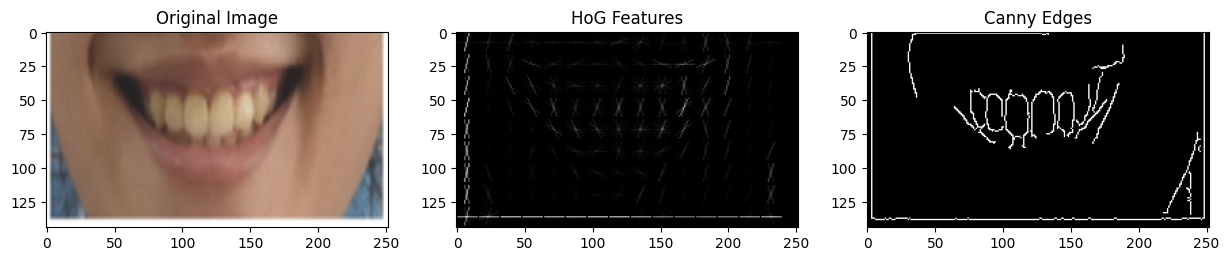

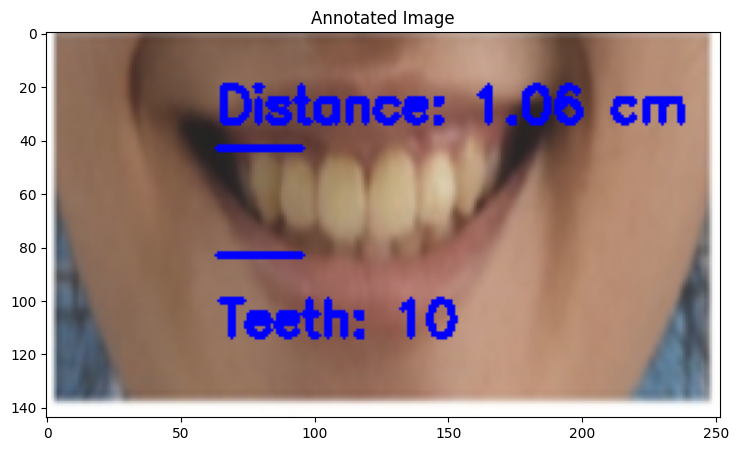

Image: 17.png is Less Smiling


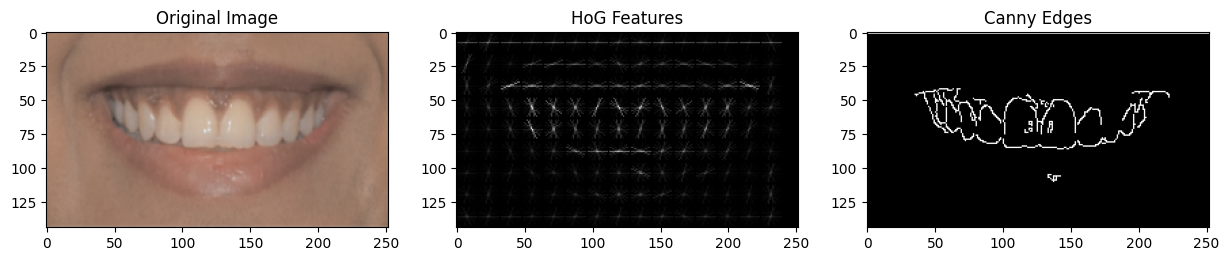

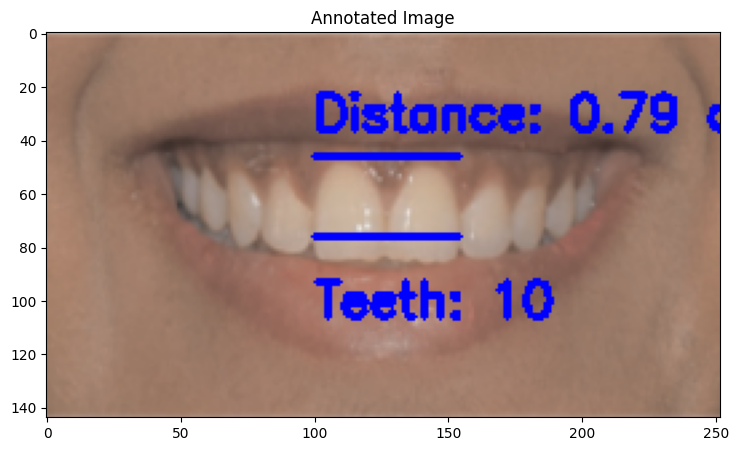

Image: 12.png is Less Smiling


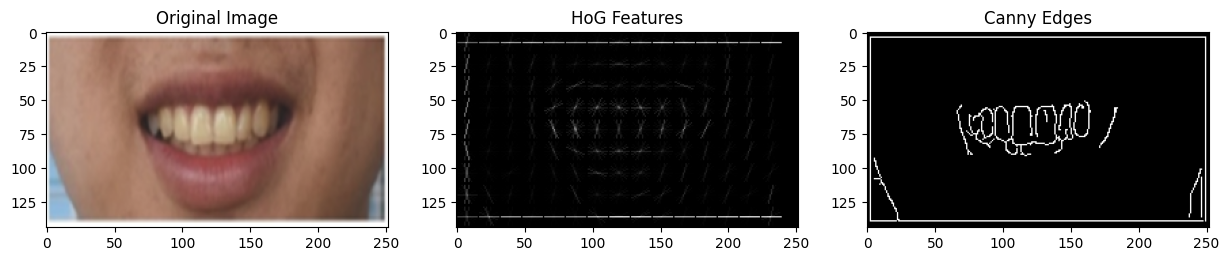

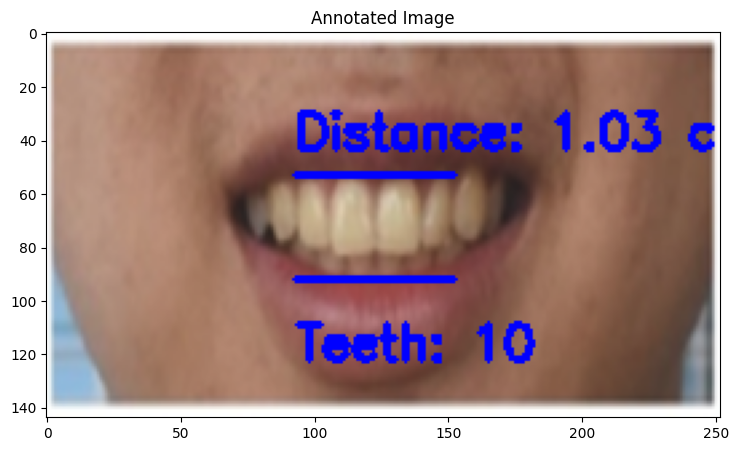

Image: 2.png is More Smiling


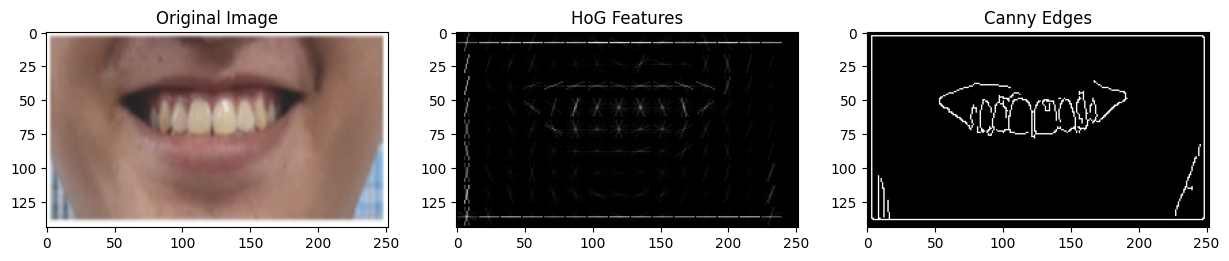

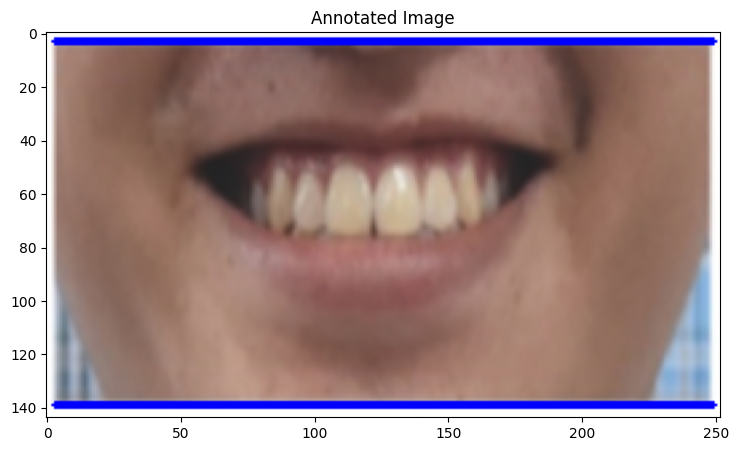

Image: 22.png is Less Smiling


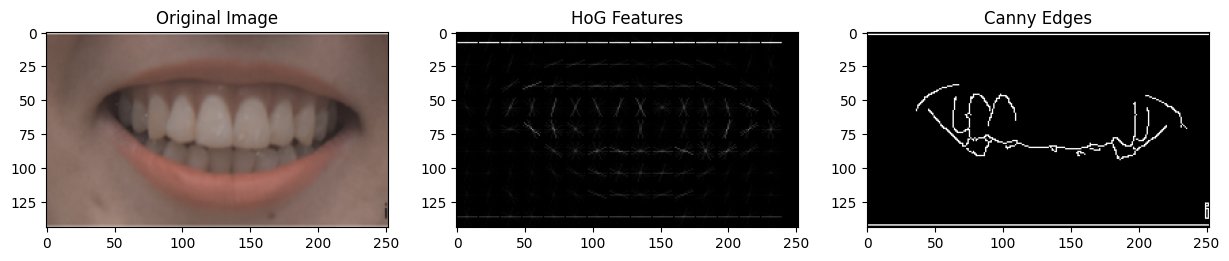

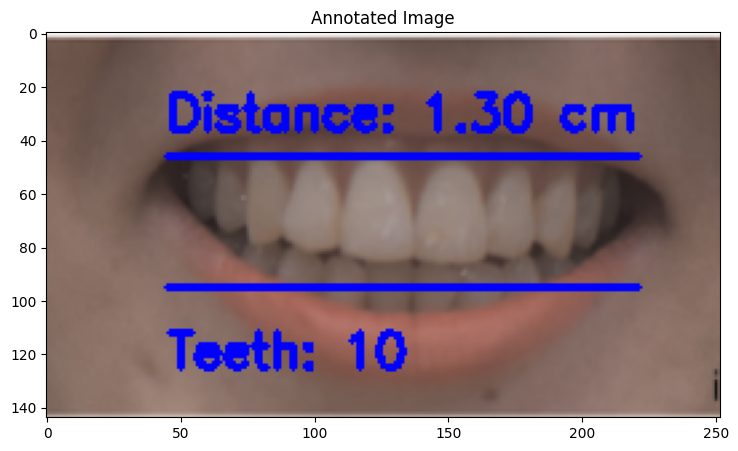

Image: 14.png is Less Smiling


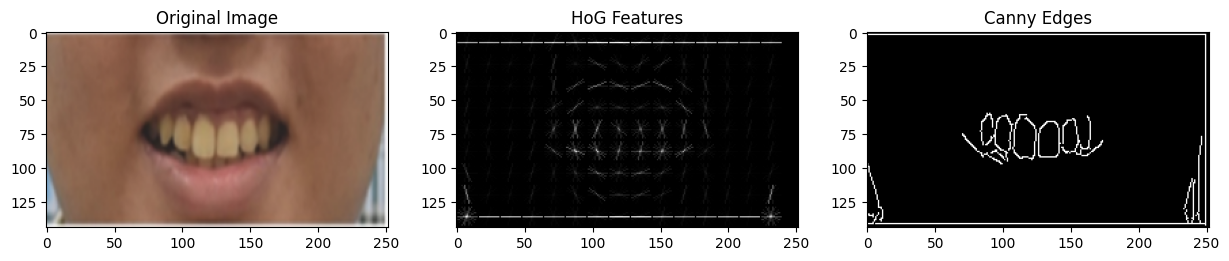

In [ ]:
def analyze_and_compare(images, image_paths):
    for i, image in enumerate(images):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hog_features, hog_image = hog(gray_image, block_norm='L2-Hys', pixels_per_cell=(16, 16),
                                      cells_per_block=(2, 2), visualize=True, feature_vector=True)
        edges = cv2.Canny(gray_image, threshold1=50, threshold2=150)
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        teeth_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
        number_of_teeth = len(teeth_contours)
        lips_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(lips_contour)
        upper_lip_y = y
        lower_lip_y = y + h
        distance_in_pixels = lower_lip_y - upper_lip_y
        pixels_per_cm = 37.795275591
        distance_in_cm = distance_in_pixels / pixels_per_cm
        label = 1 if distance_in_cm > 1.5 and number_of_teeth > 8 else 0  # Example thresholds

        smile_status = "More Smiling" if label == 1 else "Less Smiling"
        print(f"Image: {os.path.basename(image_paths[i])} is {smile_status}")

        annotated_image = image.copy()
        cv2.line(annotated_image, (x, upper_lip_y), (x + w, upper_lip_y), (255, 0, 0), 2)
        cv2.line(annotated_image, (x, lower_lip_y), (x + w, lower_lip_y), (255, 0, 0), 2)
        cv2.putText(annotated_image, f"Distance: {distance_in_cm:.2f} cm", (x, upper_lip_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        cv2.putText(annotated_image, f"Teeth: {number_of_teeth}", (x, lower_lip_y + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')

        plt.subplot(1, 3, 2)
        plt.imshow(hog_image, cmap='gray')
        plt.title('HoG Features')

        plt.subplot(1, 3, 3)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny Edges')

        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.title('Annotated Image')

        plt.show()

analyze_and_compare(images, image_paths)
